In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def detect_and_match_features(img1, img2):

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Feature Detection and Matching
    # Harris Corner Detector
    harris_parameters = dict(
        blockSize=2,
        ksize=3,
        k=0.04
    )

    corners1 = cv2.cornerHarris(gray1, **harris_parameters)
    corners2 = cv2.cornerHarris(gray2, **harris_parameters)

    # Perform non-maximal suppression on the corners
    threshold = 0.01 * corners1.max()
    corner_mask1 = (corners1 > threshold).astype(np.uint8)
    corner_mask2 = (corners2 > threshold).astype(np.uint8)

    # SIFT Descriptor
    sift = cv2.SIFT_create()

    keypoints1, descriptors1 = sift.detectAndCompute(gray1, corner_mask1)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, corner_mask2)

    # Feature Matching
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    return keypoints1, keypoints2, matches

In [41]:
def image_stitching(img1, img2, keypoints1, keypoints2, matches, threshold=0.75):

    # Apply Lowe's ratio test to select good matches
    good_matches = []
    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches.append(m)

    # Print count of good matches
    # print(len(good_matches))

    # Robust Recovery of Homography using RANSAC
    dst_1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(dst_1, dst_2, cv2.RANSAC, 5.0)

    # Image Stitching
    # resize image02 if the size of two images are different
    if not img1.shape == img2.shape:
        img2 = cv2.resize(img2, (img1.shape[0], img1.shape[1]))
    result = cv2.warpPerspective(img1, M, ((img1.shape[1] + img2.shape[1]), img2.shape[0])) #wraped image

    # now paste them together
    result[0:img2.shape[0], 0:img2.shape[1]] = img2
    result[0:img1.shape[0], 0:img1.shape[1]] = img1

    # Crop black borders from the result for a cleaner panorama
    h, w = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).shape
    result = result[0:h, 0:w]

    return result

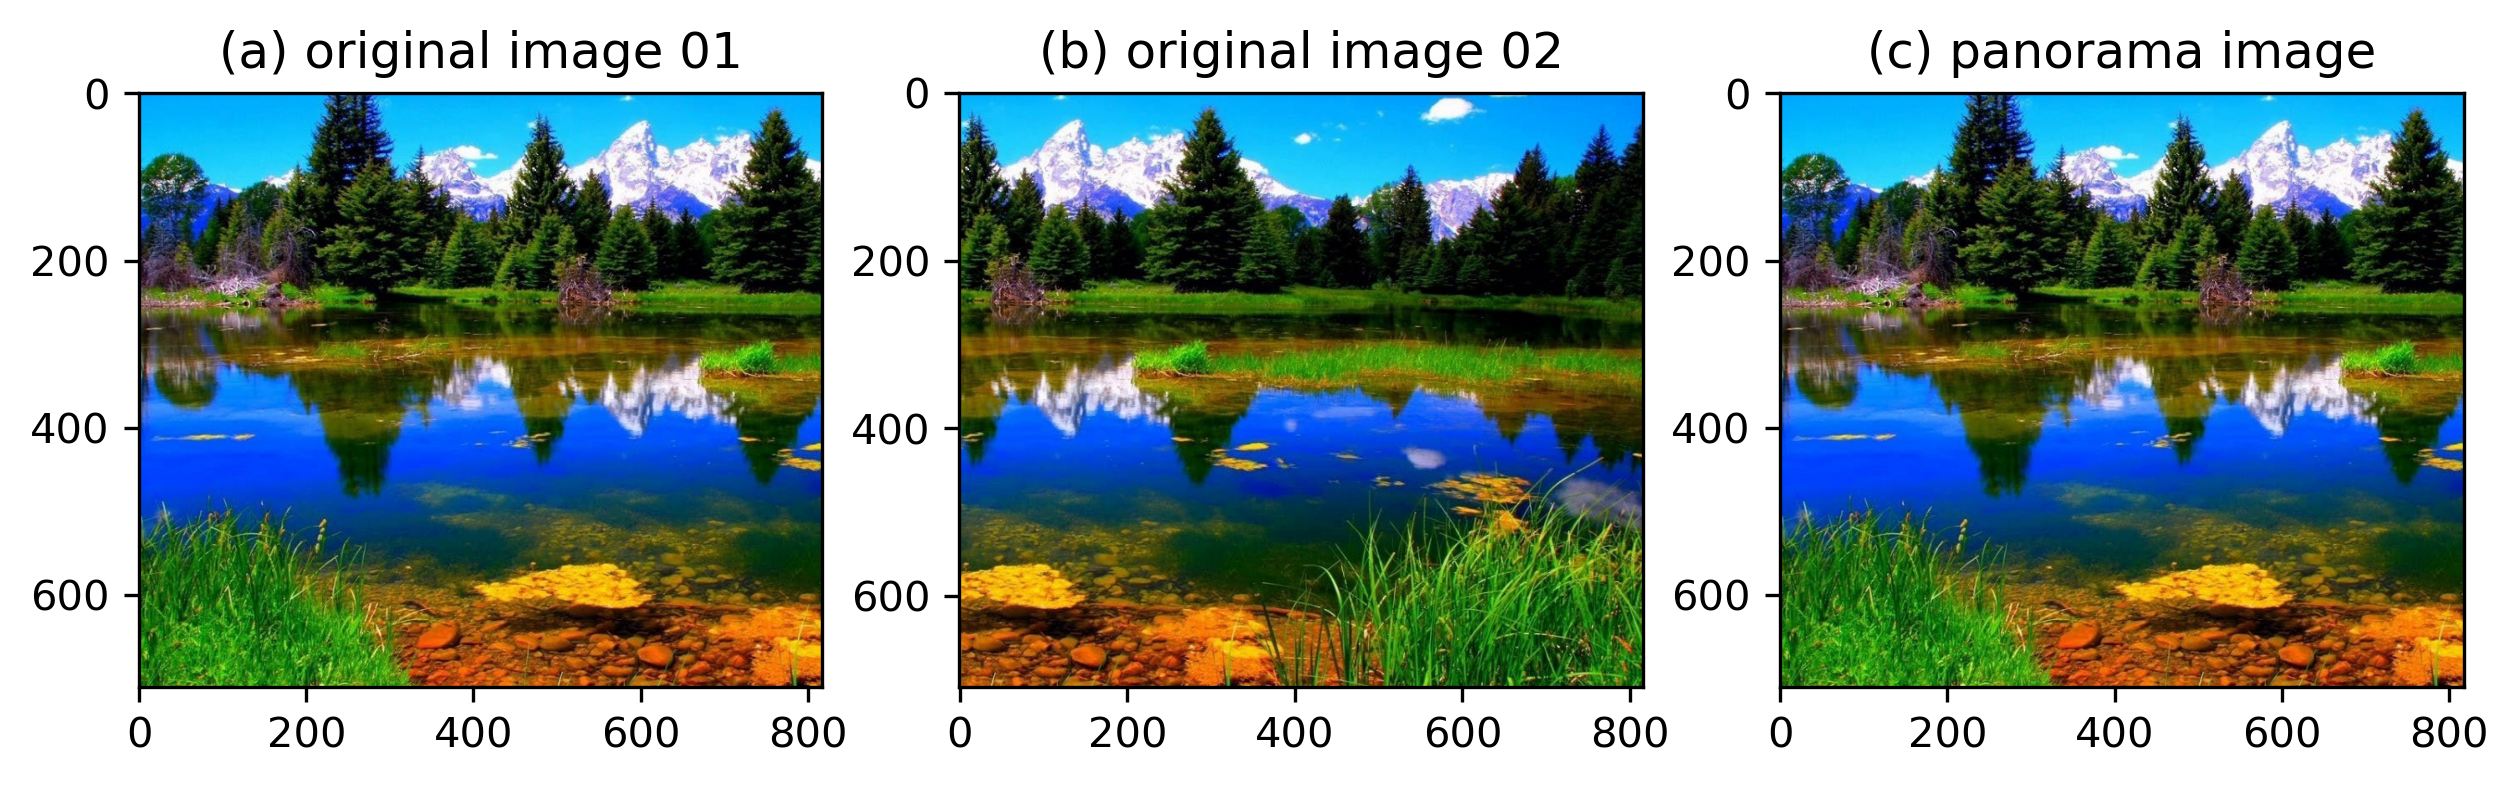

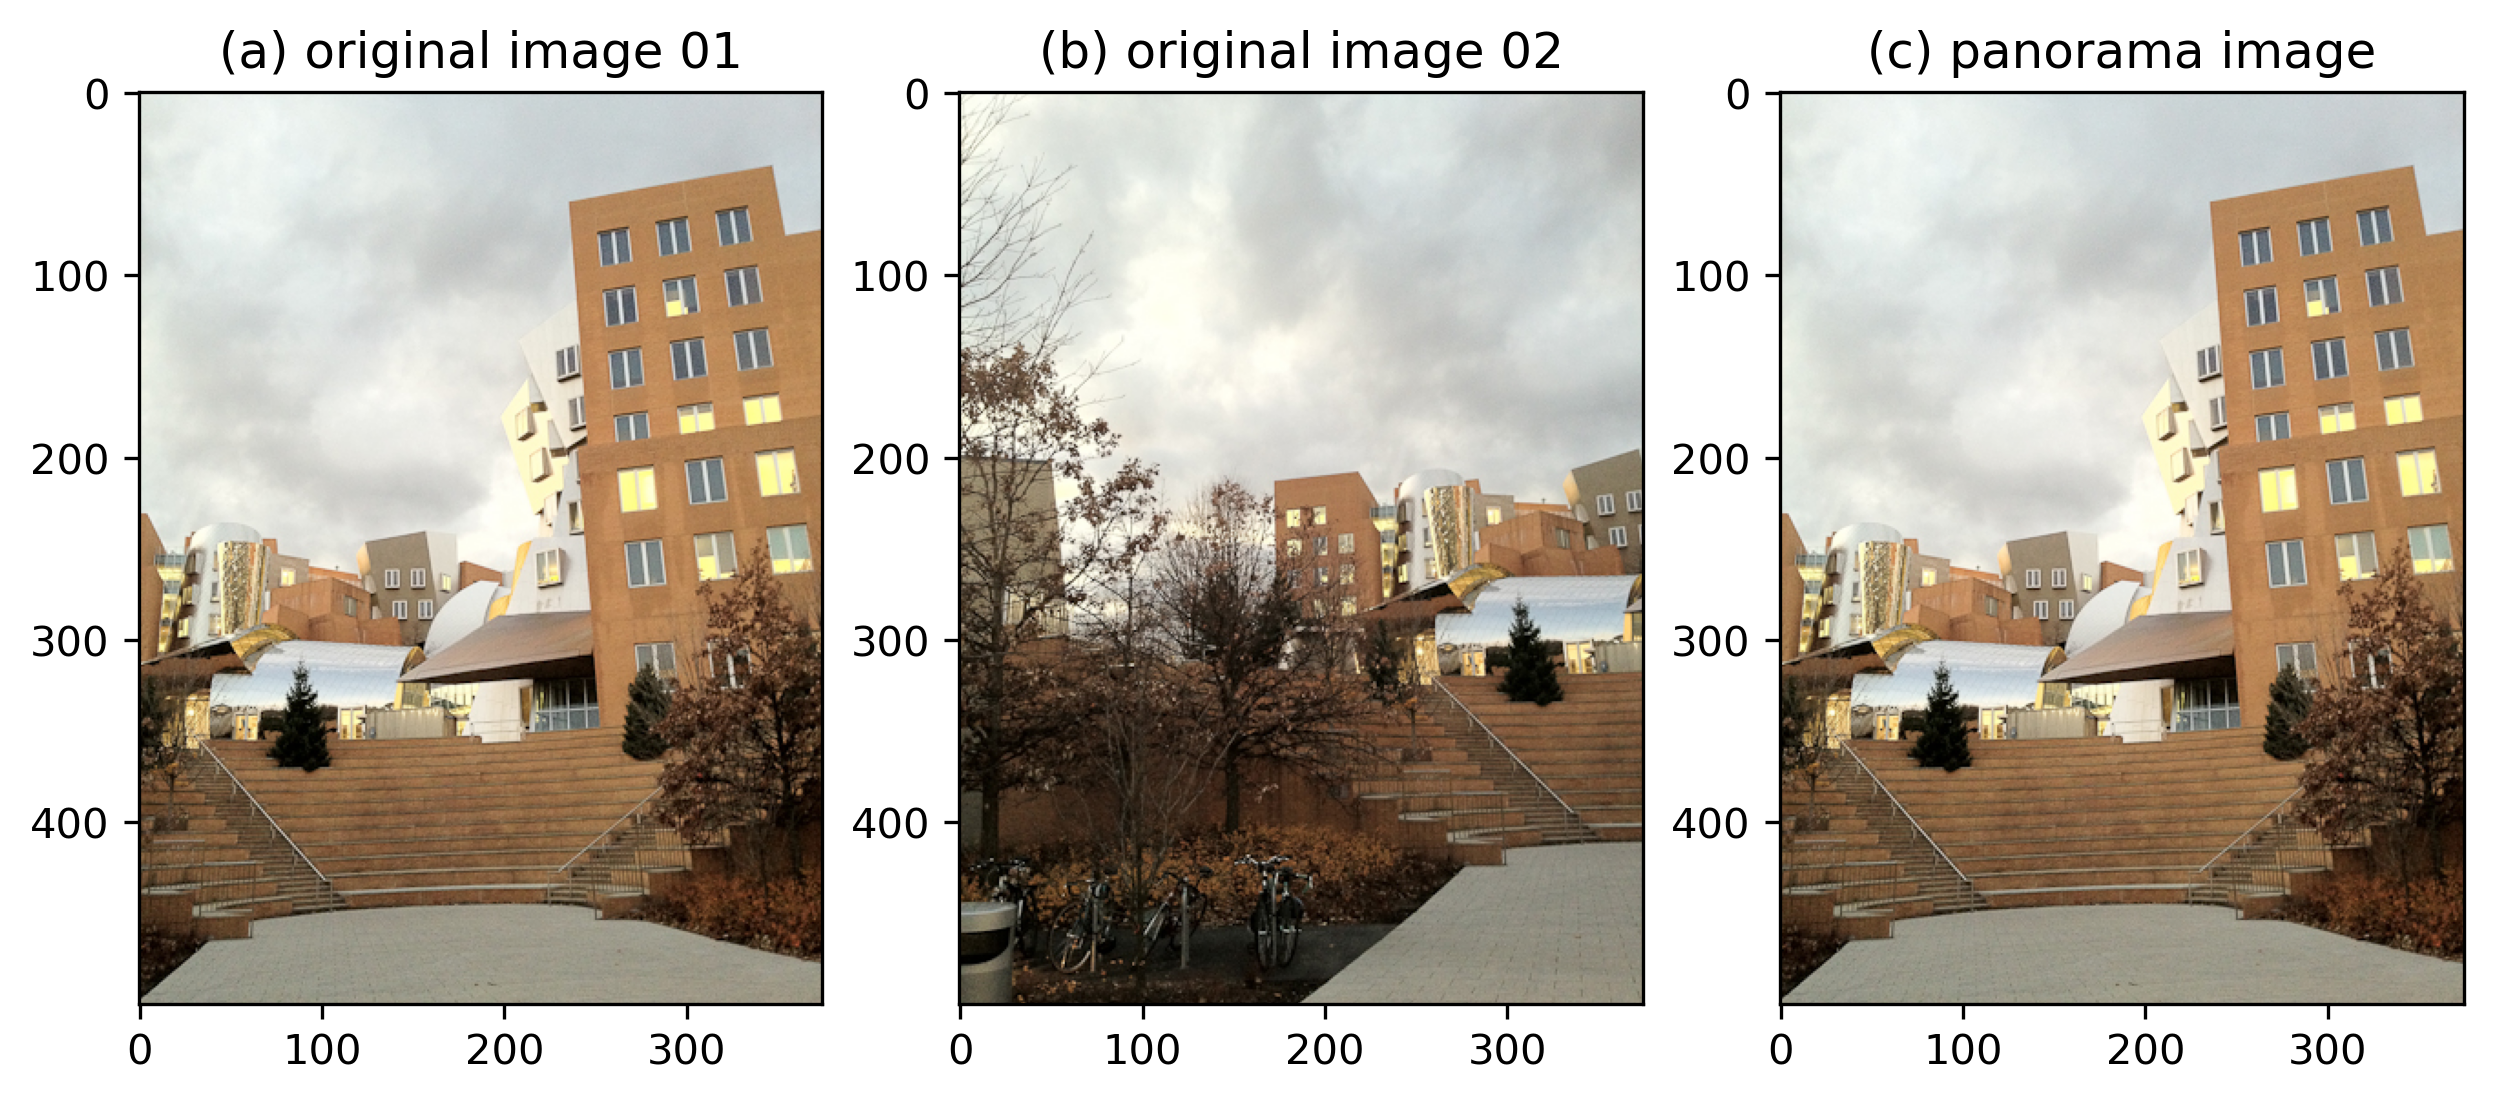

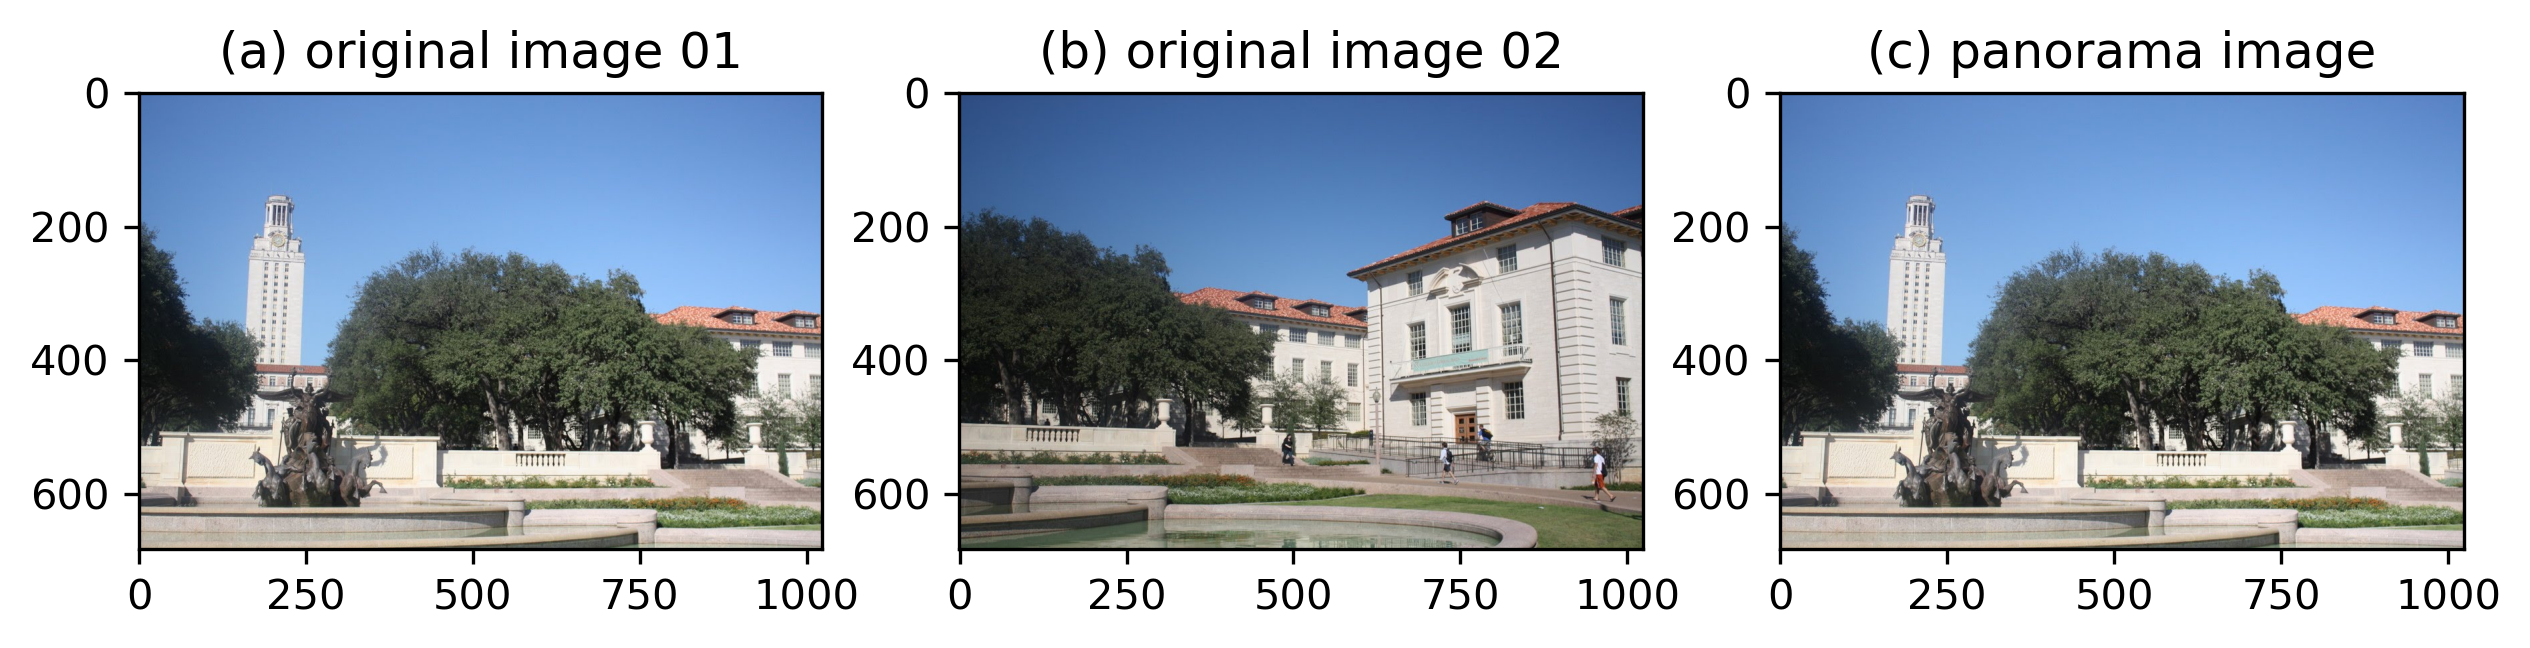

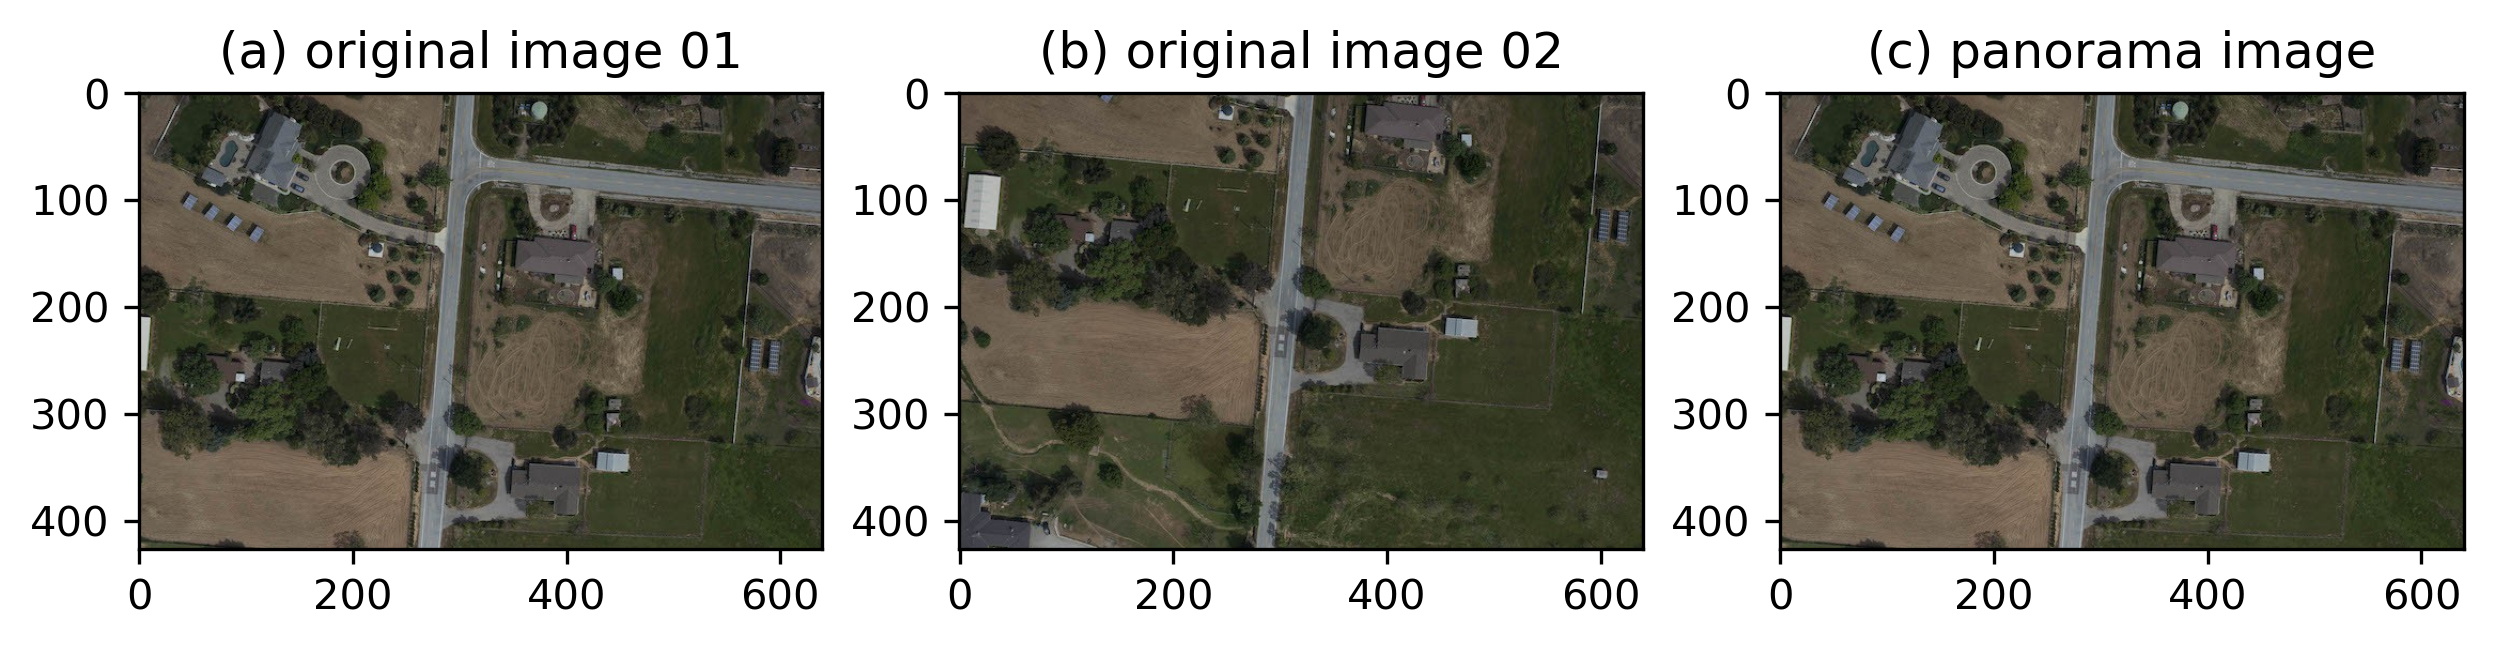

In [42]:
# load 
base_path = 'image_pairs/'
img1_list = ['image_pairs_01_01.jpg', 'image_pairs_02_01.png', 'image_pairs_03_01.jpg', 'image_pairs_04_01.jpg']
img2_list = ['image_pairs_01_02.jpg', 'image_pairs_02_02.png', 'image_pairs_03_02.jpg', 'image_pairs_04_02.jpg']

for i in range(0, len(img1_list)):
    img1 = cv2.imread(base_path + img1_list[i])
    img2 = cv2.imread(base_path + img2_list[i])

    keypoints1, keypoints2, matches = detect_and_match_features(img1, img2)
    result = image_stitching(img1, img2, keypoints1, keypoints2, matches)

    plt.figure(figsize=(10, 5), dpi=300)
    plt.subplot(1, 3, 1)
    plt.title('(a) original image 01')
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 2)
    plt.title('(b) original image 02')
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 3, 3)
    plt.title('(c) panorama image')
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))